##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support

##### Transform to tensor

In [2]:
class FacadeDataset(Dataset):
    def __init__(self, image_dir, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def load_annotations(self, annotation_file):
        with open(annotation_file) as f:
            data = json.load(f)
        
        boxes = []
        labels = []
        
        for shape in data["shapes"]:
            if shape["label"] == "window":
                points = shape["points"]
                
                # Calculate bounding box from polygon points
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                x_min = min(x_coords)
                y_min = min(y_coords)
                x_max = max(x_coords)
                y_max = max(y_coords)
                
                # Bounding box format: [x_min, y_min, width, height]
                box = [x_min, y_min, x_max - x_min, y_max - y_min]
                boxes.append(box)
                labels.append(1)  # Use 1 for "window" category label

        return {"boxes": boxes, "labels": labels}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        annotation_path = os.path.join(self.annotations_dir, f"{os.path.splitext(img_name)[0]}.json")

        image = Image.open(img_path).convert("RGB")
        annotations = self.load_annotations(annotation_path)

        # Convert bounding boxes and labels to tensors
        boxes = torch.tensor(annotations["boxes"], dtype=torch.float32)
        labels = torch.tensor(annotations["labels"], dtype=torch.int64)

        if self.transform:  
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target


# Define transformations
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Directories for training
train_image_dir = os.path.join("ZJU_dataset", "images")
train_annotations_dir = os.path.join("ZJU_dataset", "annotation")

# Create dataset
dataset = FacadeDataset(train_image_dir, train_annotations_dir, transform=transform)

# print("Dataset :", dataset[0])

print("Dataset length:", len(dataset))

Dataset length: 2556


##### Split the dataset

In [3]:
# Define the proportions for train, validation, and test
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Load the full dataset (assuming train_annotations includes all data at this stage)
full_dataset = FacadeDataset(train_image_dir, train_annotations_dir, transform=transform)

# Calculate lengths of each split
train_size = int(train_ratio * len(full_dataset))
val_size = int(val_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 1789
Validation dataset size: 511
Test dataset size: 256


##### Prepare Data Loaders

In [4]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print("Train dataset:", len(train_dataset))
print("Validation dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

Train dataset: 1789
Validation dataset: 511
Test dataset: 256


##### Checking the input data

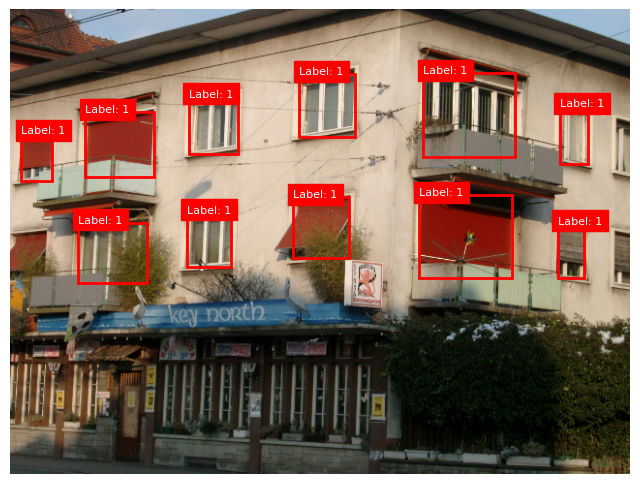

In [5]:
def visualize_sample(dataset, idx):
    # Retrieve image and target from dataset
    image, target = dataset[idx]
    boxes = target['boxes']
    labels = target['labels']
    
    # Convert the tensor image to a numpy array for visualization
    image = image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    
    # Add bounding boxes
    for box, label in zip(boxes, labels):
        # Unpack the box coordinates
        xmin, ymin, width, height = box
        rect = patches.Rectangle(
            (xmin, ymin), width, height, linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        # Optional: Add label text if you have a mapping from `label` to class names
        ax.text(xmin, ymin, f"Label: {label.item()}", color="white", fontsize=8, backgroundcolor="red")
    
    plt.axis("off")
    plt.show()

# Test visualization with a sample from the train_dataset
visualize_sample(train_dataset, idx=45)  # Change idx to visualize other samples


##### Define The Model

In [ ]:
# Define the model
num_classes = 2  # Change this to the number of classes you have (including background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### Define a fucntion to convert the bounding boxes to x_min, y_min, x_max, y_max format instead of W, H

In [7]:
def convert_bounding_boxes(targets):
    for target in targets:
        boxes = target['boxes']
        converted_boxes = []
        for box in boxes:
            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            converted_boxes.append([x_min, y_min, x_max, y_max])
        target['boxes'] = torch.tensor(converted_boxes, dtype=torch.float32)
    return targets

##### Check if Cuda is avaliable and what GPU does it use

In [8]:
# Check if CUDA is available and print the device being used
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce GTX 1660 Ti


##### Train The Model

In [ ]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set up the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 1
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, targets in train_loader:
        targets = convert_bounding_boxes(targets)
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")
    
    # Evaluation metrics on validation set
    model.eval()
    with torch.no_grad():
        all_precisions, all_recalls, all_f1s, ious = [], [], [], []
        
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Get predictions
            outputs = model(images)
            pred_boxes = [output['boxes'].cpu() for output in outputs]
            targets = convert_bounding_boxes(targets)
            target_boxes = [target['boxes'].cpu() for target in targets]

            # print("Predicted Boxes:", pred_boxes)
            # print("targeted Boxes:", target_boxes)
            
            # Calculate IoU for each image
            batch_ious = []
            for pb, tb in zip(pred_boxes, target_boxes):
                if pb.size(0) > 0 and tb.size(0) > 0:
                    iou = box_iou(pb, tb)
                    batch_ious.append(iou.max(dim=1).values.mean().item())  # Mean IoU per prediction
            ious.extend(batch_ious)
            
            # Calculate precision, recall, F1 at IoU 0.5 threshold
            for pb, tb in zip(pred_boxes, target_boxes):
                if pb.size(0) > 0 and tb.size(0) > 0:
                    iou = box_iou(pb, tb)
                    tp = (iou >= 0.5).sum().item()
                    fp = pb.size(0) - tp
                    fn = tb.size(0) - tp
                    
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                    
                    all_precisions.append(precision)
                    all_recalls.append(recall)
                    all_f1s.append(f1)

        # Calculate mean metrics over the entire validation set
        mean_iou = sum(ious) / len(ious) if ious else 0
        mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
        mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
        mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

        print(f"Validation Metrics - Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  Mean IoU: {mean_iou:.4f}")
        print(f"  Precision at IoU 0.5: {mean_precision:.4f}")
        print(f"  Recall at IoU 0.5: {mean_recall:.4f}")
        print(f"  F1 Score at IoU 0.5: {mean_f1:.4f}")

    model.train()

print("Training complete!")


Epoch [1/2], Loss: 0.5975
Validation Metrics - Epoch [1/2]
  Mean IoU: 0.4786
  Precision at IoU 0.5: 0.4984
  Recall at IoU 0.5: 1.0458
  F1 Score at IoU 0.5: 0.6428
Epoch [2/2], Loss: 0.4766
Validation Metrics - Epoch [2/2]
  Mean IoU: 0.4448
  Precision at IoU 0.5: 0.4698
  Recall at IoU 0.5: 1.0385
  F1 Score at IoU 0.5: 0.6089
Training complete!


##### Define a function for visualizing the results (predicitons)

In [10]:
def visualize_predictions(predictions, image_tensor, threshold=0.5, class_names=None):
    """
    Visualizes predictions on an image.

    Args:
        predictions (dict): The predictions dictionary from Faster R-CNN, containing 'boxes', 'labels', and 'scores'.
        image_tensor (Tensor): The image tensor.
        threshold (float): Confidence threshold to filter boxes.
        class_names (list): List of class names, where index corresponds to class label (optional).
    """
    # Convert the tensor to a PIL image
    img = transforms.ToPILImage()(image_tensor.cpu())
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    # Draw each bounding box
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:  # Filter boxes by score
            x_min, y_min, x_max, y_max = box.detach().cpu().numpy()
            width, height = x_max - x_min, y_max - y_min

            # Draw the rectangle
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Get label name if provided, otherwise use label index
            label_text = class_names[label] if class_names else f"Class {label}"
            label_text = f"{label_text}: {score:.2f}"

            # Add label and score
            ax.text(x_min, y_min - 10, label_text, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

##### Visualzing the results (predictions) on the test subset

In [ ]:
model.eval()
class_names = ["background", "window"]  # Add your class names here, with "background" as the first item
ind = 2  # Index of the image you want to visualize

with torch.no_grad():
    for batch_idx, (images, _) in enumerate(test_loader):
        images = [image.to(device) for image in images]
        predictions = model(images)

        # Check if the desired index is within this batch
        if ind >= batch_idx * len(images) and ind < (batch_idx + 1) * len(images):
            relative_index = ind - batch_idx * len(images)  # Relative index within the current batch
            print(f"Visualizing predictions for image {ind}")
            visualize_predictions(predictions[relative_index], images[relative_index], threshold=0.5, class_names=class_names)
            break  # Exit the loop after visualizing the desired image


##### Visualizing the results (predictions) on the Evalution subset

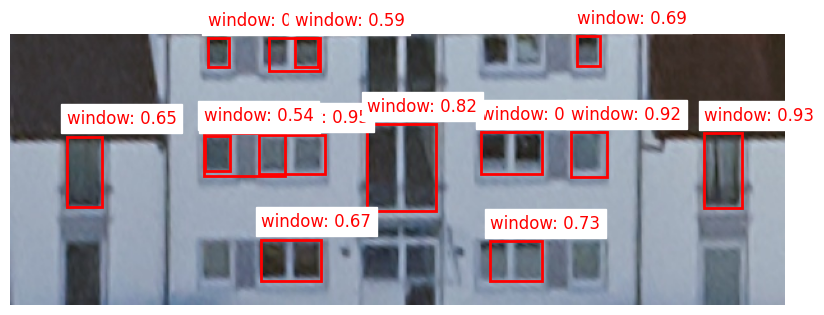

In [12]:
# Define the path to your image
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3LU.jpg")

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
with torch.no_grad():
    predictions = model(input_image)

# Visualize the predictions
class_names = ["background", "window"]  # Adjust based on your class names
visualize_predictions(predictions[0], input_image[0], threshold=0.5, class_names=class_names)